### Análise do ano de 2019

Utilizando como base o trabalho descrito em "https://sol.sbc.org.br/index.php/bwaif/article/view/24959", este notebook desenvolverá um alocador de portfólio baseado em aprendizado por reforço, sendo sua performance avaliada ao longo do ano de 2019.

In [5]:
# Importação do diretório atual de trabalho
import sys
upper_path = sys.path[0][:-8]
sys.path.append(upper_path)

# Importação d0 módulo responsável por criar o banco de dados personalizado
from quantamental_lib import RLDatabase

# Importação de bibliotecas auxiliares
import pandas as pd
import torch

In [6]:
# Criação dos bancos de dados. Os dados de treino e teste são igualmente distribuídos com base na quantidade máxima de ativos selecionada (30).
rl_db = RLDatabase(end_train = '2018-12-31',end_test='2019-12-31', test_time_window=50)

# Leitura ou criação dos DataFrames de treino e teste
try:
    train_df = pd.read_csv('train_test_dfs/train_2019.csv')
except:
    train_df = rl_db.create_train_database()
    train_df.to_csv('train_test_dfs/train_2019.csv', index=False)

try:
    test_df = pd.read_csv('train_test_dfs/test_2019.csv')
except:
    test_df = rl_db.create_test_database()
    test_df.to_csv('train_test_dfs/test_2019.csv', index=False)

# Universo de tickers disponíveis
br_tickers = train_df.tic.unique()

print(br_tickers)

['ABEV3' 'B3SA3' 'BBAS3' 'BBDC4' 'BHIA3' 'BRFS3' 'CCRO3' 'CIEL3' 'CMIG4'
 'CPLE6' 'CSAN3' 'CSNA3' 'EQTL3' 'FNOR11' 'GGBR4' 'GOAU4' 'GOLL4' 'ITSA4'
 'ITUB4' 'JBSS3' 'MGLU3' 'MRVE3' 'PETR3' 'PETR4' 'RADL3' 'RENT3' 'USIM5'
 'VALE3' 'WEGE3']


### Treino do modelo

O ambiente será treinado ao longo de 100 episódios, sendo sua taxa de aprendizado igual a 0.001.

In [7]:
# Importação do módulo contendo as principais classes necessárias para o treinamento
from quantamental_lib.finRL_POE import *

# Definição das features que serão avaliados pelo modelo
features = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'mom', 'cci', 'stoch',
       'williams', 'macd', 'macd_signal', 'bband', 'USD/BRL', 'IBOV', 'SPX',
       'DJI', 'CDI', 'NASDAQ', 'IPCA', 'SELIC', 'IGPM', 'day']


In [3]:
# Ambiente de Treino
environment = PortfolioOptimizationEnv(
        train_df,
        initial_amount=100000,
        comission_fee_pct=0,
        time_window=50,
        features=features
    )

# Treinamento do modelo
algo = PG(environment, lr=0.001, portfolio_size = len(br_tickers))
algo.train(episodes=100)

# Salvando o modelo treinado
torch.save(algo.target_policy.state_dict(), "trained_models/policy_EIIE_2019.pt")

  0%|          | 0/100 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 457125.8125
Final accumulative portfolio value: 4.571258125
Maximum DrawDown: -0.4553015720634762
Sharpe ratio: 1.1140701310248537
Initial portfolio value:100000
Final portfolio value: 470938.3125
Final accumulative portfolio value: 4.709383125
Maximum DrawDown: -0.4537567424046268
Sharpe ratio: 1.1324131997710074
Initial portfolio value:100000
Final portfolio value: 485996.625
Final accumulative portfolio value: 4.85996625
Maximum DrawDown: -0.4518670145628283
Sharpe ratio: 1.1528718705541965
Initial portfolio value:100000
Final portfolio value: 505402.90625
Final accumulative portfolio value: 5.0540290625
Maximum DrawDown: -0.45019851069567707
Sharpe ratio: 1.1773805539923932
Initial portfolio value:100000
Final portfolio value: 538245.1875
Final accumulative portfolio value: 5.382451875
Maximum DrawDown: -0.44706369121469247
Sharpe ratio: 1.216935390917382
Initial portfolio value:100000
Final portfolio value: 590388.0625
Final ac

## Teste do modelo

Após o treinamento, será criado um novo ambiente de teste utilizado para a avaliação de sua performance no ano de 2019.

In [8]:
# Ambiente de teste
environment_test = PortfolioOptimizationEnv(
        test_df,
        initial_amount=100000,
        comission_fee_pct=0,
        time_window=50,
        features=features
    )

# Importação e preparação do modelo treinado
policy = GradientPolicy()
policy.load_state_dict(torch.load("trained_models/policy_EIIE_2019.pt"))
policy = policy.to(device)

# Obtenção das métricas ao longo de 2019
done = False
obs = environment_test.reset()
pvm = PVM(environment_test.episode_length, portfolio_size=len(br_tickers))
while not done:
    last_action = pvm.retrieve()
    obs_batch = np.expand_dims(obs, axis=0)
    last_action_batch = np.expand_dims(last_action, axis=0)
    action = policy(obs_batch, last_action_batch)
    pvm.add(action)
    obs, _, done, _ = environment_test.step(action)


Initial portfolio value:100000
Final portfolio value: 108390.3203125
Final accumulative portfolio value: 1.083903203125
Maximum DrawDown: -0.19994357818257402
Sharpe ratio: 0.43676881288446384


## Avaliação dos resultados

Realização de uma análise da performance ao longo de 2019.

In [9]:
# Importação do módulo responsável por avaliar a performance doo modelo ao longo de seu teste
from quantamental_lib import Backtest

bk = Backtest(test_environment= environment_test, portfolio_vector = pvm)

In [10]:
# Criação de um DataFrame contendo os retornos da estratégia e dos principais benchmarks (CDI e IBOV)
df = bk.general_cumulative_daily_returns()

# Salva o DataFrame em um arquivo CSV
df.to_csv('results_df/results_2019.csv', index=True)

display(df)

,Cumulative Daily Returns,IBOV,CDI
2019-01-03,1.000000,1.000000,1.000246
2019-01-04,0.985513,1.003025,1.000492
2019-01-07,0.970905,1.001474,1.000739
2019-01-08,0.970905,1.005111,1.000985
2019-01-09,0.986963,1.022378,1.001232
...,...,...,...
2019-12-20,1.111783,1.257274,1.058252
2019-12-23,1.102861,1.265377,1.058433
2019-12-26,1.106449,1.280012,1.058795
2019-12-27,1.103628,1.272705,1.058976


In [11]:
# Avaliação do índice de Sharpe do modelo
sharpe_ratio = bk.sharpe_ratio(risk_free_rate=0)
print('Sharpe Ratio: ', sharpe_ratio)

# Avaliação da taxa de acerto do modelo
hit_ratio = bk.hit_ratio()
print('Hit ratio: ', hit_ratio)

Sharpe Ratio:  0.4969094499312388
Hit ratio:  0.4875


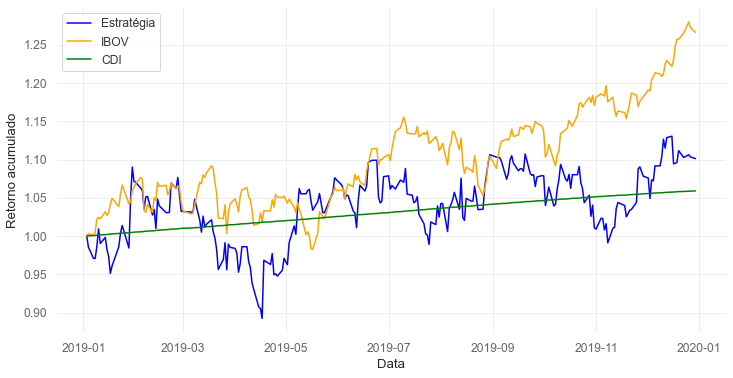

In [12]:
# Plotagem dos resultados para facilitar sua comparação
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6)) 

plt.plot(df['Cumulative Daily Returns'], label='Estratégia', color ='blue')  
plt.plot(df['IBOV'], label='IBOV', color ='orange')  
plt.plot(df['CDI'], label='CDI', color ='green')  

plt.legend()

plt.ylabel('Retorno acumulado')
plt.xlabel('Data')

plt.show()